# Histogramming and fitting

The aim of this exercise is to try something that is very commonly done: taking some data, making a histogram, and then fitting it. You can work from this notebook, since notebooks aren't just for a bunch of code but can also contain text, headers, etc.

## Initialization

There are some things that we are going to need for sure: numpy, matplotlib, scipy. Best put them all at the start of your notebook. Write the imports in the following cell:

In [1]:
import numpy as np
import scipy
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
%matplotlib inline

Neat little trick: you can stow away your imports in a separate notebook, and run it from this one. This is done with something called 'cell magic' (no joke). Try it!

In [2]:
%run 'def.ipynb'

Imports done.


## Reading in data

There is a text file in this folder called 'data.txt'. Read it in with your favorite package. If this costs you more than one line, you're being inefficient.

In [3]:
data = np.loadtxt('data.txt')

## Plot a histogram

Now use matplotlib to plot a histogram. Try the following arguments (for example) range=(-1, 2), bins=100, histtype='step', normed=True. See what the arguments do and find your best-looking plot

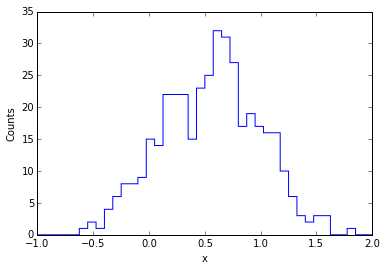

In [4]:
plt.hist(data, histtype='step', bins=40, range=(-1, 2))
plt.xlabel('x')
plt.ylabel('Counts')
plt.show()

## Guessing the values

Needless to say, the distribution looks Gaussian. A good starting point for a fit is often just to plot the fit function on top of the histogram. Define a fit function and try a few values until you find some good starting values.

In [5]:
def gauss(x, A, mu, sigma):
    return A * np.exp(-(x-mu)**2/(2 * sigma**2))

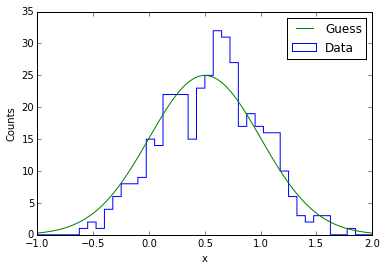

In [6]:
plt.hist(data, histtype='step', bins=40, range=(-1, 2), label='Data')
xplot = np.linspace(-1, 2, 100)
plt.plot(xplot, gauss(xplot, 25, 0.5, 0.5), label='Guess')
plt.xlabel('x')
plt.ylabel('Counts')
plt.legend()
plt.show()

## Extracting the data

In Python, you don't directly fit the histogram, but you rather take the data from it first and then fit that. Extract the data from the histogram with the following lines:

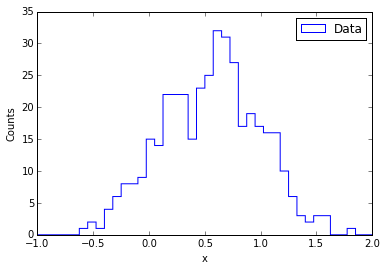

In [7]:
counts, bin_edges, _ = plt.hist(data, histtype='step', bins=40, range=(-1, 2), label='Data')
plt.xlabel('x')
plt.ylabel('Counts')
plt.legend()
plt.show()

If you don't want to *show* the histogram, use np.histogram instead. It has the same syntax, but doesn't take all the plot style arguments.

In [8]:
counts, bin_edges = np.histogram(data, bins=40, range=(-1, 2))

By default, the bin *edges* are extracted. For a fit, we want to have the bin *centers*. Note that this list is one element shorter. Extract the bin centers.

In [9]:
bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])

As a check, plot the counts versus the bin_centers and see that it resembles the histogram. If you want, you can do 'ls=steps' or 'ls=steps_mid' for a more histogrammy look.

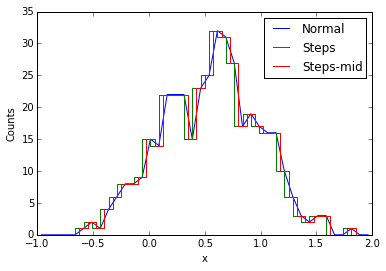

In [10]:
plt.plot(bin_centers, counts, label='Normal')
plt.plot(bin_centers, counts, ls='steps', label='Steps')
plt.plot(bin_centers, counts, ls='steps-mid', label='Steps-mid')
plt.xlabel('x')
plt.ylabel('Counts')
plt.legend()
plt.show()

## Fitting the extracted histogram

Next, fit your Gaussian function with curve_fit:

In [11]:
popt, pcov = curve_fit(gauss, bin_centers, counts, p0=[25, 0.5, 0.5])

For documentation on curve_fit, execute the following cell:

In [12]:
curve_fit?

After executing this cell, you get some values out:

In [13]:
print(popt)

[ 26.4723843    0.56813946   0.45771336]


## The uncertainties

These are the optimized values. But wait! Did we put the errors in somewhere? No, so curve_fit just guesses them. In fact, we do know the bin-by-bin errors, since we're doing a counting experiment (yay particle physics!). The error on the number of counts is just the square root, in the limit of large N. Let's extract the error on the counts.

In [14]:
counts_err = np.sqrt(counts)

If you have zero counts somewhere, the counts will go zero too and your fitting will fail. Check if there are zeros in your error array.

In [15]:
counts_err

array([ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        1.        ,  1.41421356,  1.        ,  2.        ,  2.44948974,
        2.82842712,  2.82842712,  3.        ,  3.87298335,  3.74165739,
        4.69041576,  4.69041576,  4.69041576,  3.87298335,  4.79583152,
        5.        ,  5.65685425,  5.56776436,  5.19615242,  4.12310563,
        4.35889894,  4.12310563,  4.        ,  4.        ,  3.16227766,
        2.44948974,  1.73205081,  1.41421356,  1.73205081,  1.73205081,
        0.        ,  0.        ,  1.        ,  0.        ,  0.        ])

There may or may not be zeros in there. Write a function to replace all zeros in an array with ones. Can you do a one-liner again?

In [16]:
def replace_zeros(arr):
    return (arr == 0) * 1 + arr

In [17]:
counts_err = replace_zeros(counts_err)

Now, refit and check the influence on the result.

In [18]:
popt0, pcov0 = curve_fit(gauss, bin_centers, counts, p0=[25, 0.5, 0.5])
popt1, pcov1 = curve_fit(gauss, bin_centers, counts, p0=[25, 0.5, 0.5], sigma=counts_err)

In [19]:
print('No   errs: ', popt0)
print('With errs: ', popt1)

No   errs:  [ 26.4723843    0.56813946   0.45771336]
With errs:  [ 26.18827808   0.55109063   0.43552112]


Scipy also returns the covariance matrix, pcov. If the errors are not correlated (check this for any serious analysis, but assume here), this is how you get the errors:

In [20]:
perr = np.sqrt(np.diag(pcov1))

Hey, time to print your result!

In [21]:
print('==== My awesome fit! =======')
print('A:     %.4f +- %.4f' % (popt1[0], perr[0]))
print('mu:    %.4f +- %.4f' % (popt1[1], perr[1]))
print('sigma: %.4f +- %.4f' % (popt1[2], perr[2]))

==== My awesome fit! =======
A:     26.1883 +- 1.2908
mu:    0.5511 +- 0.0180
sigma: 0.4355 +- 0.0135


## Bins, fit range, and your result...

Well, wasn't that easy? But wait, *you* put in the number of bins and the histogram range. Doesn't that influence your result? Well, maybe. Let's try two methods. First, let's vary the fit range and number of bins and see what it does to the results. After that, we can try something a little more advanced: unbinned fits!

Write a function that does all you've just done: extract the histogram, bin it, get the data, fit it, return the parameters. Be sure to put comments in, because this will be a longer function.

In [22]:
def fit_it(arr, hist_range, hist_bins, plot_it=False):
    # Make a histogram and extract the data
    counts, bin_edges = np.histogram(data, bins=hist_bins, range=hist_range)
    
    # Get the bin centers
    bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])
    
    # Get the errors
    counts_err = np.sqrt(counts)
    
    # Replace with ones if zeros are found
    counts_err = replace_zeros(counts_err)
    
    # Fit it
    popt, pcov = curve_fit(gauss, bin_centers, counts, p0=[25, 0.5, 0.5], sigma=counts_err)
    
    # Optional: plot the fitted gaussian
    if plot_it:
        plt.hist(data, bins=hist_bins, range=hist_range)
        xplot = np.linspace(*hist_range, num=50)
        plt.plot(xplot, gauss(xplot, *popt))
        plt.show()
        
    return popt

Next, vary the number of bins and see what happens.

In [23]:
try_bins = [10, 20, 30, 50, 70, 100] # List or array of the number of bins you'd like to try
popts = np.array([fit_it(data, hist_range=(-0.6, 1.8), hist_bins=hist_bins) for hist_bins in try_bins])

Check what happens to the parameters.

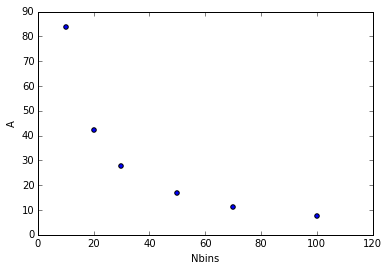

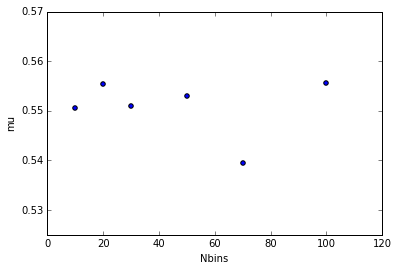

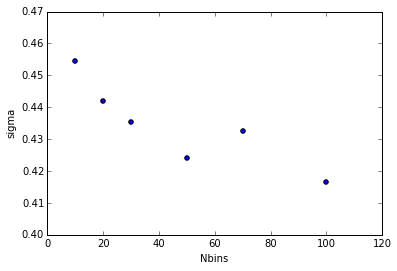

In [24]:
plt.scatter(try_bins, popts[:, 0])
plt.ylabel('A')
plt.xlabel('Nbins')
plt.show()

plt.scatter(try_bins, popts[:, 1])
plt.ylabel('mu')
plt.xlabel('Nbins')
plt.show()

plt.scatter(try_bins, popts[:, 2])
plt.ylabel('sigma')
plt.xlabel('Nbins')
plt.show()

Now do the same thing for the range.

In [25]:
halfranges = [ 0.4, 0.6, 0.8, 1.2, 1.6]
try_range = [(0.5 - halfrange, 0.5 + halfrange) for halfrange in halfranges ]
popts = np.array([fit_it(data, hist_range=hist_range, hist_bins=100) for hist_range in try_range])

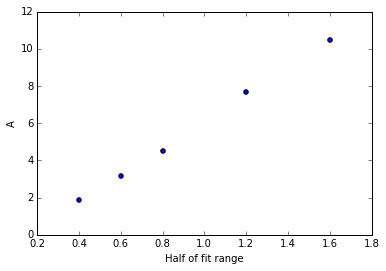

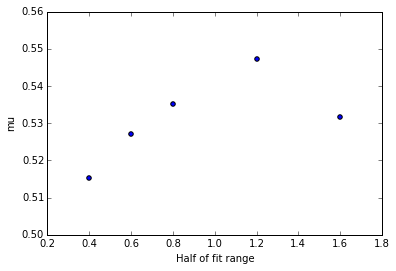

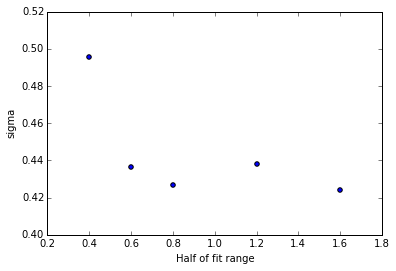

In [26]:
plt.scatter(halfranges, popts[:, 0])
plt.ylabel('A')
plt.xlabel('Half of fit range')
plt.show()

plt.scatter(halfranges, popts[:, 1])
plt.ylabel('mu')
plt.xlabel('Half of fit range')
plt.show()

plt.scatter(halfranges, popts[:, 2])
plt.ylabel('sigma')
plt.xlabel('Half of fit range')
plt.show()

Based on what you have just seen, do you think the uncertainties you got before are OK?

In [27]:
print(perr)

[ 1.29084315  0.01803417  0.01348479]


To me they seem a little small.

## Unbinned fits

Unbinned fits are a little more tricky: you don't get the nice curve_fit routine, but on the plus side: no dependence on fit range, no stupid unphysical zero errors and you can impress everyone by saying 'unbinned fit'. Let's go!

Fitting is the process of minimizing the negative log likelihood. Wow. For this, we define the probability density function: in our case, just the Gaussian again, but normalized. Define it here.

In [28]:
def gauss_norm(x, mu, sigma):
    return 1/(sigma * np.sqrt(2 * np.pi)) * gauss(x, 1, mu, sigma)

Here is the log likelihood:

In [29]:
def loglikelihood(arr, mu, sigma):
    return np.log(gauss_norm(arr, mu, sigma))

And this is what we wish to minimize:

In [30]:
def neglog(mu, sigma):
    return -np.sum(loglikelihood(data, mu, sigma))

Check the behavior: if we fix sigma to (approximately) the right value and vary mu, what does it do?

In [31]:
sigma_fix = 0.5
mu_guesses = np.linspace(0, 1, 11) #
values = [neglog(mu, sigma_fix) for mu in mu_guesses]

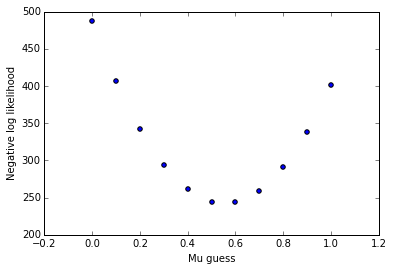

In [32]:
plt.scatter(mu_guesses, values)
plt.xlabel('Mu guess')
plt.ylabel('Negative log likelihood')
plt.show()

Now use a minimizing routing (scipy.optimize.minimize, for example, or iMinuit if you have it installed) to find the best-fit values.

In [33]:
m = scipy.optimize.minimize(lambda x: neglog(*x), x0=[1, 0.5])

In [34]:
m.x

array([ 0.55399221,  0.43569828])

## Challenge yourself!

If you haven't got enough already, try:
  * Limiting the data to see what happens at lower statistics.
  * Read the data with uniform background, and modify the fit function to take it into account.